# FSC curve of empiar10311_stack_crop.mrc VS several sigma values in Stucture Preserving Gaussian Denoising

In [1]:
import mrcfile
import matplotlib.pyplot as plt
from self_fourier_shell_correlation import fsc_utils as fsc # pip install --upgrade --force-reinstall "self_fourier_shell_correlation @ git+https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation"
from denoising.volume.gaussian import Monochrome_Denoising as GD # pip install --upgrade --force-reinstall "denoising @ git+https://github.com/vicente-gonzalez-ruiz/denoising"
from denoising.volume.OF_gaussian import Monochrome_Denoising as SPGD # pip install --upgrade --force-reinstall "denoising @ git+https://github.com/vicente-gonzalez-ruiz/denoising"
from denoising.utils import get_gaussian_kernel # pip install --upgrade --force-reinstall "denoising @ git+https://github.com/vicente-gonzalez-ruiz/denoising"
import numpy as np
import logging

import opticalflow3D # pip install opticalflow3d ... requires python 3.10
from numba.core.errors import NumbaPerformanceWarning
import warnings; warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

ModuleNotFoundError: No module named 'mrcfile'

In [2]:
vol_name = "empiar10311_stack_crop"
vol_extension = ".mrc"
vols_path = "/mnt2/TomogramDenoising/vols/"

In [3]:
from collections import namedtuple # Comes with the PSL
Args = namedtuple("args", ["vol"])
args = Args(vols_path + vol_name + vol_extension)

In [4]:
with mrcfile.open(args.vol, permissive=True) as mrc:
    vol= mrc.data

In [5]:
vol.shape

(100, 1024, 1024)

In [6]:
vol = vol[0:100, 0:100, 0:100]

In [7]:
Z_dim = vol.shape[0]
Z2 = Z_dim//2
#plt.imshow(vol[Z2], cmap="gray")

In [8]:
def get_kernel_coeffs(sigma):
    sigmas = np.array([sigma, sigma, sigma])
    kernel = [None]*3
    kernel[0] = get_gaussian_kernel(sigmas[0])
    kernel[1] = get_gaussian_kernel(sigmas[1])
    kernel[2] = get_gaussian_kernel(sigmas[2])
    return kernel

In [9]:
sigma = 2.0
kernel = get_kernel_coeffs(sigma)

In [10]:
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [11]:
denoiser = GD(logger)
vol_denoised = denoiser.filter(vol, kernel)

[gaussian.py:99 filter()] mean=163.9285430908203
[gaussian.py:101 filter()] filtered along Z
[gaussian.py:103 filter()] filtered along Y
[gaussian.py:105 filter()] filtered along X


In [12]:
#plt.imshow(vol_denoised[Z2], cmap="gray")

In [13]:
freq, c_GD = fsc.get_FSC_curve(vol, vol_denoised)

In [14]:
denoiser = SPGD(logger)
vol_denoised = denoiser.filter(vol, kernel, l=2, w=5)
freq, c_SPGD = fsc.get_FSC_curve(vol, vol_denoised)

[OF_gaussian.py:23 __init__()] logger: <Logger __main__ (INFO)>
[OF_gaussian.py:23 __init__()] pyramid_levels: 1
[OF_gaussian.py:23 __init__()] window_side: 5
[OF_gaussian.py:23 __init__()] sigma_poly: 1.0
[OF_gaussian.py:23 __init__()] num_iters: 3
[OF_gaussian.py:23 __init__()] N_poly: 5
[gaussian.py:99 filter()] mean=163.9285430908203
[gaussian.py:101 filter()] filtered along Z
[gaussian.py:103 filter()] filtered along Y
[gaussian.py:105 filter()] filtered along X


In [15]:
#plt.imshow(vol_denoised[Z2], cmap="gray")

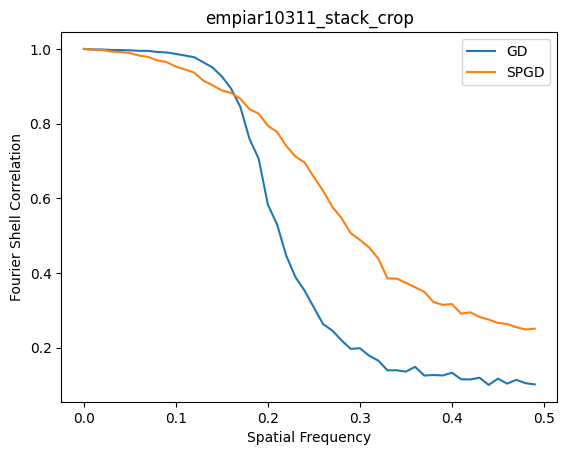

In [16]:
plt.title(vol_name)
plt.xlabel("Spatial Frequency")
plt.ylabel("Fourier Shell Correlation")
plt.plot(freq, c_GD, label=f"GD")
plt.plot(freq, c_SPGD, label=f"SPGD")
plt.legend()
plt.savefig(vol_name + "_GD_vs_SPGD" + ".svg")
plt.show()

In [17]:
FSC_threshold = 0.5

In [18]:
np.sum(c_GD[c_GD > FSC_threshold])

np.float64(20.06379384402497)

In [19]:
np.sum(c_SPGD[c_SPGD > FSC_threshold])

np.float64(25.445184969044018)